Total training images 1595
Total training images (Damaged) 1365
Total training images (Damaged) 230

Total validation images 459
Total training images (Damaged) 229
Total training images (Damaged) 230

Total Number of Images:  2054


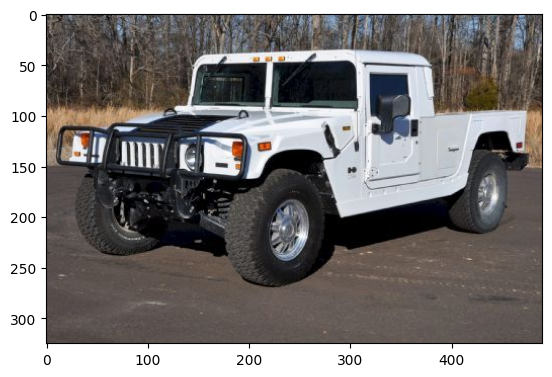

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

DataDir = "./Dataset"
train_dir = os.path.join(DataDir, 'training/')
val_dir = os.path.join(DataDir, 'validation/')
train_damage = os.path.join(train_dir, '00-damage')
train_not_damage = os.path.join(val_dir, '01-whole')
num_train_damage = len(os.listdir(train_damage))
num_train_not_damage = len(os.listdir(train_not_damage))
val_damage = os.path.join(val_dir, '00-damage')
val_not_damage = os.path.join(val_dir, '01-whole')
num_val_damage = len(os.listdir(val_damage))
num_val_not_damage = len(os.listdir((val_not_damage)))
num_train = num_train_damage + num_train_not_damage
num_val = num_val_damage + num_val_not_damage


# Total images
total_images = num_val + num_train
print("Total training images",num_train)
print("Total training images (Damaged)", num_train_damage)
print("Total training images (Damaged)", num_train_not_damage)
print()

print("Total validation images", num_val)
print("Total training images (Damaged)", num_val_damage)
print("Total training images (Damaged)", num_val_not_damage)
print()

print("Total Number of Images: ",total_images)

plt.grid('')
image = plt.imread('./Dataset/training/01-whole/0003.jpg')
plt.imshow(image)
plt.show()


In [9]:
# hyperparameters
initial_lr = 0.001
epochs = 100
batch_size = 64

# Classes
classes = ["00-damage", "01-whole"]

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError 

print("[INFO] loading images...")

data = [] 
labels = []  

for class_ in classes:
    path = os.path.join(train_dir, class_)
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        try:
            image_ = load_img(image_path, target_size=(224, 224))
            image_ = img_to_array(image_)
            image_ = preprocess_input(image_)
            
            data.append(image_)
            labels.append(class_)
        except UnidentifiedImageError:
            print(f"[WARNING] Skipping file {image_path}, as it is not a valid image.")

for class_ in classes:
    path = os.path.join(val_dir, class_)
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        try:
            image_ = load_img(image_path, target_size=(224, 224))
            image_ = img_to_array(image_)
            image_ = preprocess_input(image_)

            data.append(image_)
            labels.append(class_)
        except UnidentifiedImageError:
            print(f"[WARNING] Skipping file {image_path}, as it is not a valid image.")

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


[INFO] loading images...
[WARNING] Skipping file ./Dataset\training/00-damage\COCO_mul_train_annos.json, as it is not a valid image.
[WARNING] Skipping file ./Dataset\training/00-damage\COCO_train_annos.json, as it is not a valid image.
[WARNING] Skipping file ./Dataset\training/01-whole\.directory, as it is not a valid image.


In [12]:
from tensorflow.keras.optimizers import legacy

# Load the base MobileNetV2 model
model_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the model head
model_head = model_base.output
model_head = MaxPooling2D(pool_size=(5, 5))(model_head)
model_head = Flatten(name="flatten")(model_head)
model_head = Dense(128, activation="relu")(model_head)
model_head = Dropout(0.5)(model_head)
model_head = Dense(2, activation="softmax")(model_head)

# Define the final model
model_final = Model(inputs=model_base.input, outputs=model_head)

# Freeze the base model layers
for layer in model_base.layers:
    layer.trainable = False

# Import Adam optimizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optim = Adam(learning_rate=lr_schedule)

# Compile the model
model_final.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])


C:\Users\walte\AppData\Local\Temp\ipykernel_24676\2207222935.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [13]:

# train the head of the network
model_train = model_final.fit(
	aug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)


predict = model_final.predict(testX, batch_size=batch_size)
predict_index = np.argmax(predict, axis=1)

print(classification_report(testY.argmax(axis=1), predict_index,
	target_names=lb.classes_))

model_final.save("Car_detection.model.h5")

c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_159']. Received: the structure of inputs=*
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6704 - loss: 1.4052 - val_accuracy: 0.8352 - val_loss: 0.4071
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.4297   
Epoch 3/100


c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8008 - loss: 0.4542 - val_accuracy: 0.8656 - val_loss: 0.3548
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.9062 - loss: 0.3331 
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8320 - loss: 0.3774 - val_accuracy: 0.8704 - val_loss: 0.3346
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8125 - loss: 0.4154 
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 982ms/step - accuracy: 0.8563 - loss: 0.3691 - val_accuracy: 0.8944 - val_loss: 0.2791
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.8281 - loss: 0.3586 
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8540 - loss: 0.3526 - val_accuracy: 0.8352 - val_loss: 0.3686
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.8281 - loss: 0.4423 
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8627 - loss: 0.3322 - val_accuracy: 0.8816 - val_loss: 0.2993
Epoch 12/100
39/39 ━

              precision    recall  f1-score   support

   00-damage       0.92      0.89      0.90       318
    01-whole       0.89      0.92      0.90       307

    accuracy                           0.90       625
   macro avg       0.90      0.90      0.90       625
weighted avg       0.90      0.90      0.90       625



In [14]:
print(model_train.history.keys())



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [15]:
%matplotlib inline
import os
print(os.getcwd())

c:\Users\walte\Downloads\0Github\PRJ_FINAL\DroneInovation\Machinelearning-Updated\V1BasicCarDamageDetection


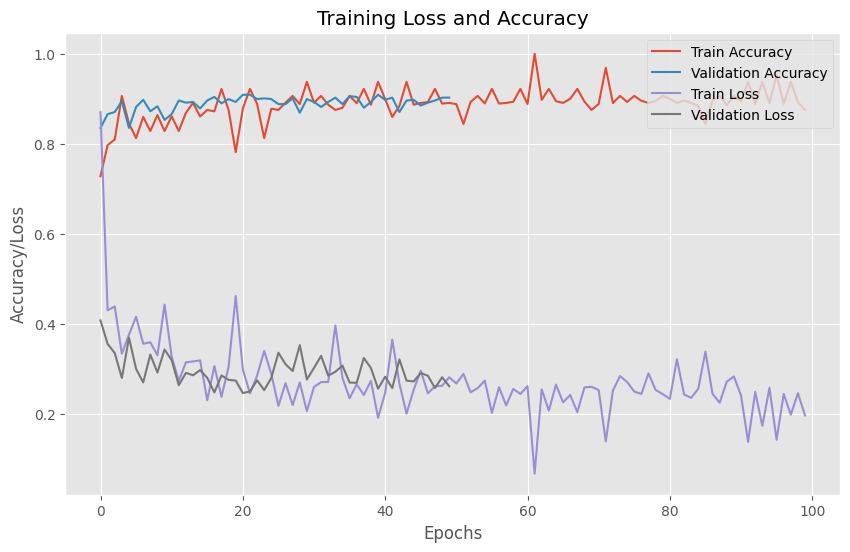

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Use a basic style that should be available
plt.style.use("ggplot")

# Define the number of epochs dynamically
num_epochs = len(model_train.history["accuracy"])

# Define the number of epochs for validation accuracy dynamically, based on the length of "val_accuracy"
num_val_epochs = len(model_train.history["val_accuracy"])

# Start plotting
plt.figure(figsize=(10, 6))

# Plot Train Accuracy
plt.plot(np.arange(0, num_epochs), model_train.history["accuracy"], label="Train Accuracy")

# Plot Validation Accuracy (ensure that both axes are the same length)
plt.plot(np.arange(0, num_val_epochs), model_train.history["val_accuracy"], label="Validation Accuracy")

# Plot Train Loss
plt.plot(np.arange(0, num_epochs), model_train.history["loss"], label="Train Loss")

# Plot Validation Loss
plt.plot(np.arange(0, num_val_epochs), model_train.history["val_loss"], label="Validation Loss")

# Set the title and labels
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="upper right")

# Save the plot as an image
plt.savefig("Car_Detection.png")
plt.show()


20/20 [==============================] - 9s 431ms/step
Prediction for sample 0: [0.99427277 0.00572724]


In [17]:

# Make predictions on test data (e.g., a single image or batch)
predictions = model_final.predict(testX)

# If you want to print predictions for a sample image
sample_idx = 0  # Adjust the index to test on different images
print(f"Prediction for sample {sample_idx}: {predictions[sample_idx]}")

# Convert predictions to class labels (e.g., 0 for non-damaged, 1 for damaged)
threshold = 0.5
predicted_class = (predictions[sample_idx] > threshold).astype(int)
print(f"Predicted class for sample {sample_idx}: {predicted_class}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step
Prediction for sample 0: [0.99549854 0.00450155]
Predicted class for sample 0: [1 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


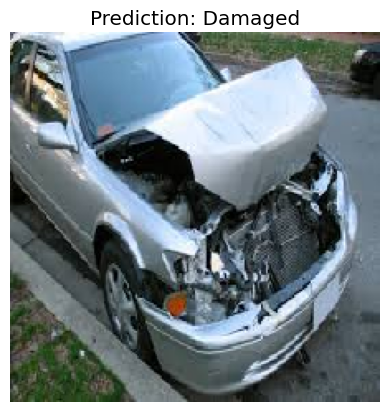

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


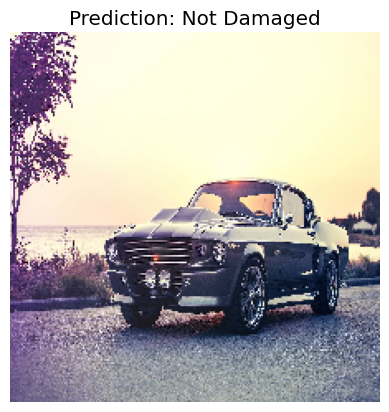

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


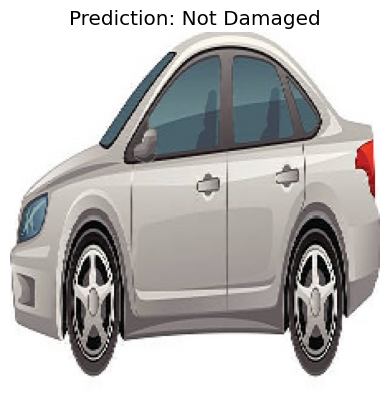

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_height, img_width = 224, 224  
img_paths = ['./images/d_img1.jpg', './images/g_img1.jpg', './images/Before/Before_test1.jpg']

for img_path in img_paths:
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0 

    # Make prediction
    prediction = model_final.predict(img_array)

    predicted_class = (prediction > 0.5).astype(int) 
    plt.imshow(img)
    plt.title(f"Prediction: {'Damaged' if predicted_class[0][0] == 1 else 'Not Damaged'}")
    plt.axis('off')  # Hide axes
    plt.show()


[INFO] Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Prediction probabilities for ./images/d_img1.jpg: [1.0000000e+00 1.6754837e-11]
Predicted class for ./images/d_img1.jpg: damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction probabilities for ./images/g_img1.jpg: [2.7978952e-12 1.0000000e+00]
Predicted class for ./images/g_img1.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction probabilities for ./images/g_img2.jpg: [9.7791835e-12 1.0000000e+00]
Predicted class for ./images/g_img2.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction probabilities for ./images/good1.jpg: [0.18298191 0.81701815]
Predicted class for ./images/good1.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction probabilities for ./Dataset/validation/00-damage/0006.JPEG: [9.9999917e-01 8.2565208e-07]
Predicted class for ./Dataset/validation/00-damage/0006.JPEG: damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction probabilities for ./Dataset/validat

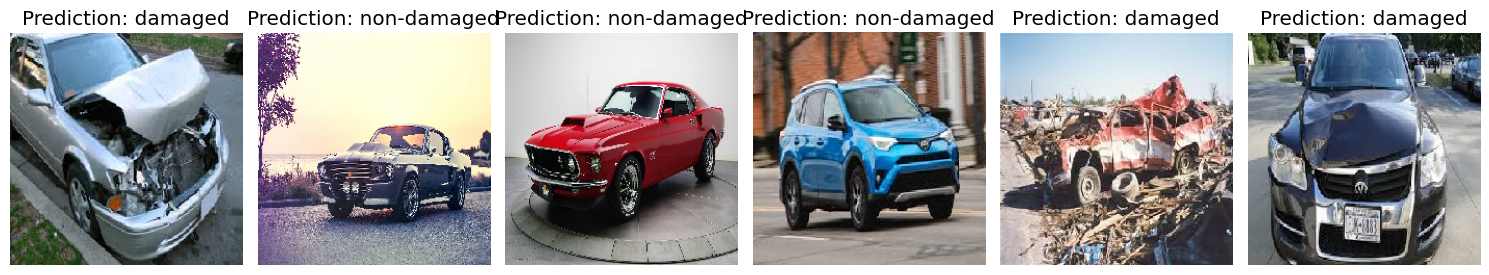

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Use this for MobileNetV2
import os

# Load the trained model
model = load_model("Car_detection.model.h5")
print("[INFO] Model loaded successfully.")

# Define class names (adjust based on your specific classes)
classes = ["damaged","non-damaged"]

# Define a function to load and preprocess an image for prediction
def prepare_image(image_path, target_size=(224, 224)):
    # Load the image and resize it
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to an array and preprocess it
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # Using preprocess_input for MobileNetV2
    
    # Expand the dimensions (since Keras expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

# Define specific image paths for testing
image_paths = [
    "./images/d_img1.jpg", 
    "./images/g_img1.jpg",  
    "./images/g_img2.jpg",
    "./images/good1.jpg",
    "./Dataset/validation/00-damage/0006.JPEG",
    "./Dataset/validation/00-damage/0050.jpeg"
]

# Set up the plot for displaying the images and predictions
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

# Loop through each image and make predictions
for idx, image_path in enumerate(image_paths):
    # Preprocess the image
    img_array, img = prepare_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Print the prediction probabilities for each image
    print(f"Prediction probabilities for {image_path}: {predictions[0]}")

    # Convert predictions to class labels (e.g., 0 for non-damaged, 1 for damaged)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the highest probability
    predicted_label = classes[predicted_class_index]  # Get class label from the predicted index
    print(f"Predicted class for {image_path}: {predicted_label}")

    # Display the image and predicted label
    axes[idx].imshow(img)
    axes[idx].set_title(f"Prediction: {predicted_label}")
    axes[idx].axis("off")  # Turn off axis for better visualization

# Show the images with their predictions
plt.tight_layout()
plt.show()


In [20]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("Car_detection.model.h5")
print("[INFO] Model loaded successfully.")

# Save the model in the TensorFlow SavedModel format
model.save("Car_detection_saved_model", save_format="tf")
print("[INFO] Model re-saved in SavedModel format.")


[INFO] Model loaded successfully.


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

[INFO] Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
Prediction probabilities for ./images/d_img1.jpg: [1.0000000e+00 1.6754837e-11]
Predicted class for ./images/d_img1.jpg: damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction probabilities for ./images/g_img1.jpg: [2.7978952e-12 1.0000000e+00]
Predicted class for ./images/g_img1.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction probabilities for ./images/g_img2.jpg: [9.7791835e-12 1.0000000e+00]
Predicted class for ./images/g_img2.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction probabilities for ./images/good1.jpg: [0.18298191 0.81701815]
Predicted class for ./images/good1.jpg: non-damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction probabilities for ./Dataset/validation/00-damage/0006.JPEG: [9.9999917e-01 8.2565208e-07]
Predicted class for ./Dataset/validation/00-damage/0006.JPEG: damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction probabilities for ./Dataset/validat

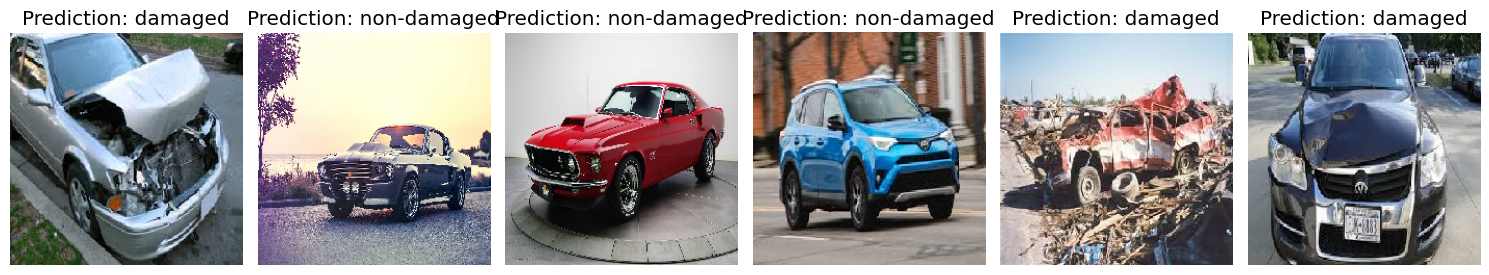

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import tensorflow as tf

# Load the trained model
model = load_model("Car_detection.model.h5")
print("[INFO] Model loaded successfully.")



# Define class names
classes = ["damaged", "non-damaged"]

# Define a function to load and preprocess an image for prediction
def prepare_image(image_path, target_size=(224, 224)):
    # Load the image and resize it
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to an array and preprocess it
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # Using preprocess_input for MobileNetV2
    
    # Expand the dimensions (since Keras expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

# Define specific image paths for testing
image_paths = [
    "./images/d_img1.jpg", 
    "./images/g_img1.jpg",  
    "./images/g_img2.jpg",
    "./images/good1.jpg",
    "./Dataset/validation/00-damage/0006.JPEG",
    "./Dataset/validation/00-damage/0050.jpeg"
]

# Set up the plot for displaying the images and predictions
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

# Loop through each image and make predictions
for idx, image_path in enumerate(image_paths):
    # Preprocess the image
    img_array, img = prepare_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Print the prediction probabilities for each image
    print(f"Prediction probabilities for {image_path}: {predictions[0]}")

    # Convert predictions to class labels
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the highest probability
    predicted_label = classes[predicted_class_index]  # Get class label from the predicted index
    print(f"Predicted class for {image_path}: {predicted_label}")

    # Display the image and predicted label
    axes[idx].imshow(img)
    axes[idx].set_title(f"Prediction: {predicted_label}")
    axes[idx].axis("off")  # Turn off axis for better visualization

# Show the images with their predictions
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

# Adjust this depending on the model format
def load_damage_detection_model(model_path):
    try:
        model = tf.saved_model.load(model_path)  # For SavedModel format
        print("[INFO] Car damage detection model loaded.")
        return model
    except Exception as e:
        print(f"[ERROR] Failed to load model: {e}")
        return None


load_damage_detection_model("./Car_detection_saved_model")

[INFO] Car damage detection model loaded.


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x21ea914a220>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Use this if you're using MobileNetV2

# Adjust this depending on the model format
def load_damage_detection_model(model_path):
    try:
        model = tf.saved_model.load(model_path)  # For SavedModel format
        print("[INFO] Car damage detection model loaded.")
        return model
    except Exception as e:
        print(f"[ERROR] Failed to load model: {e}")
        return None

# Load the model
model_path = "./Car_detection_saved_model"  # Path to your SavedModel
damage_detection_model = load_damage_detection_model(model_path)

# Function to run the model and check if the car is damaged
def is_car_damaged(image):
    # Preprocess the image (resize and normalize it as needed)
    img = load_img(image, target_size=(224, 224))  # Resize to the model's input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocessing step for MobileNetV2
    
    # Run inference using the loaded model
    # Assuming the model has an output for classification (damage vs. no damage)
    predictions = damage_detection_model(img_array)
    
    # If the model outputs a prediction, you can convert it into a binary classification
    # You can adjust this depending on how your model's output is structured
    prediction = predictions[0].numpy()  # Assuming the model output is a tensor
    return prediction[0] > 0.5  # Return True if damaged (threshold > 0.5)

# Example usage
image_path = './images/good1.jpg'  # Path to the input image
if is_car_damaged(image_path):
    print("Car is damaged.")
else:
    print("Car is not damaged.")


[INFO] Car damage detection model loaded.
Car is not damaged.
